In [63]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import scipy 
from PIL import Image
from scipy import ndimage
from lr_utils import load_dataset
import copy

In [64]:
#Loading the data (cat/non-cat)
train_x_orig, train_y, test_x_orig, test_y, classes = load_dataset()

y = 0. It's a non-cat picture.


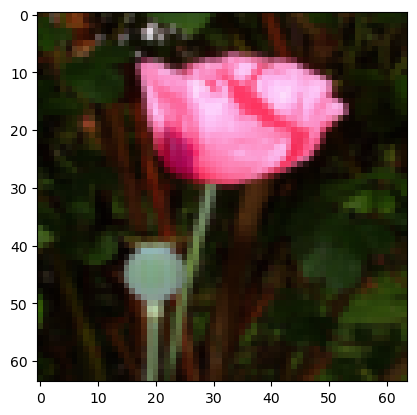

In [65]:
#Example of a picture
index = 30
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [66]:
#Explore the dataset
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("Height/Width of each image: num_px = " + str(num_px))
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: m_train = 209
Number of testing examples: m_test = 50
Height/Width of each image: num_px = 64
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


In [67]:
#Reshape the training and test examples
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

#Standardize data to have feature values between 0 and 1
train_x = train_x_flatten/255
test_x = test_x_flatten/255

print("train_x's shape: " + str(train_x.shape))
print("test_x's shape: " + str(test_x.shape))

train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


**Two-layer Neural Network**

In [68]:
# Initialize parameters 2-layer neural network
def initialize_parameters(n_x, n_h, n_y):
    np.random.seed(1)

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}

    return parameters

In [69]:
# Forward Propagation for 2-LNN
def linear_forward(A, W, b):
    Z = np.dot(W,A) + b
    cache = (A, W, b)

    return Z, cache 

In [70]:
def linear_activation_forward(A_prev, W, b, activation):

    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":
        A = 1/(1 + np.exp(-Z))
        activation_cache = Z
    elif activation == "relu":
        A = np.maximum(0,Z)
        activation_cache = Z  
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [71]:
#Compute the cost Function
def compute_cost(AL, Y):
    m = Y.shape[1]

    logprobs = np.multiply(np.log(AL),Y) + np.multiply(np.log(1 - AL), (1 - Y))
    cost = - 1/m * (np.sum(logprobs))

    cost = np.squeeze(cost)
    return cost

In [72]:
#Backward Propagation for 2-LNN
def linear_backward(dZ, cache):
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = 1/m * np.dot(dZ, A_prev.T)
    db = 1/m * np.sum(dZ, axis = 1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db

In [73]:
def relu_backward(dA, activation_cache):
    Z = activation_cache
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0

    return dZ

def sigmoid_backward(dA, activation_cache):
    Z = activation_cache
    s = 1/(1 + np.exp(-Z))
    dZ = dA * s * (1 - s)

    return dZ

In [74]:
def linear_activation_backward(dA, cache, activation):

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
    
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)

    dA_prev, dW, db = linear_backward(dZ, linear_cache)

    return dA_prev, dW, db


In [75]:
# Update Parameters
def update_parameters(parameters, grads, learning_rate):

    parameters = copy.deepcopy(parameters)
    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] -=  learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] -=  learning_rate * grads["db" + str(l+1)]

    return parameters

In [76]:
# Defining the 2-Layer Neural Network Model
n_x = train_x.shape[0]
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.0075

In [77]:
#2 Layer Neural Network Model
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost = False):

    np.random.seed(1)
    grads = {}
    costs = []
    m = X.shape[1]
    (n_x, n_h, n_y) = layers_dims

    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):

        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")

        cost = compute_cost(A2, Y)

        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")

        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2

        parameters = update_parameters(parameters, grads, learning_rate)

        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate = 0.0075):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

In [78]:
parameters, costs = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2, print_cost=False)